In [1]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils

BDC is using numpy


STANDARDIZED STARTING VARIABLES

In [23]:
T_SPECTRA = 4096/250e6

global_start_time = 1721800002
iteration_time = 1000

c_acclen = 10**6 
v_acclen = 30000

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((iteration_time)/C_T_ACCLEN)
v_nchunks = int((iteration_time)/V_T_ACCLEN)

a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"

dir_parents = []
dir_parents.append(a1_path)
dir_parents.append(a2_path)

a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2
tle_path = outils.get_tle_file(1721800002, "/project/s/sievers/mohanagr/OCOMM_TLES")

coords = []
coords.append(a1_coords)
coords.append(a2_coords)

SATELLITE INFORMATION

In [3]:
dt=5
niter = 3600 * 24 // dt  #because a file is one day I believe
alititude_cutoff = 15
rsats = outils.get_risen_sats(tle_path, a1_coords, global_start_time, dt=dt, niter = niter, altitude_cutoff=alititude_cutoff) #intervals of dt (=5s)

Starting Time of 1721800002 with a dt of 5


Text(0, 0.5, 'Sats Risen')

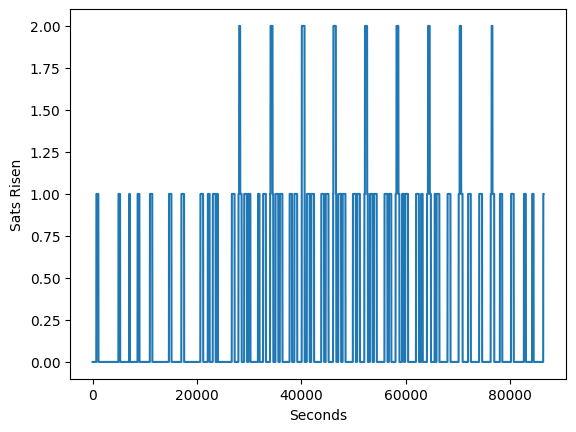

In [4]:
num_sats_risen = [len(x) for x in rsats]
plt.plot(np.arange(len(rsats))*dt,num_sats_risen)
plt.xlabel("Seconds")
plt.ylabel("Sats Risen")

(0.0, 20000.0)

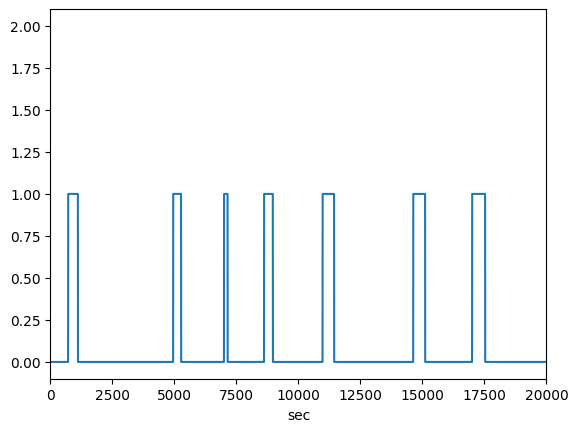

In [5]:
#zoomed in
num_sats_risen = [len(x) for x in rsats]
plt.plot(np.arange(len(rsats))*5,num_sats_risen)
plt.xlabel("sec")
plt.xlim(0,20000)

{44387, 59051, 57166, 28654, 33591, 25338}
[44387 59051 57166 28654 33591 25338]


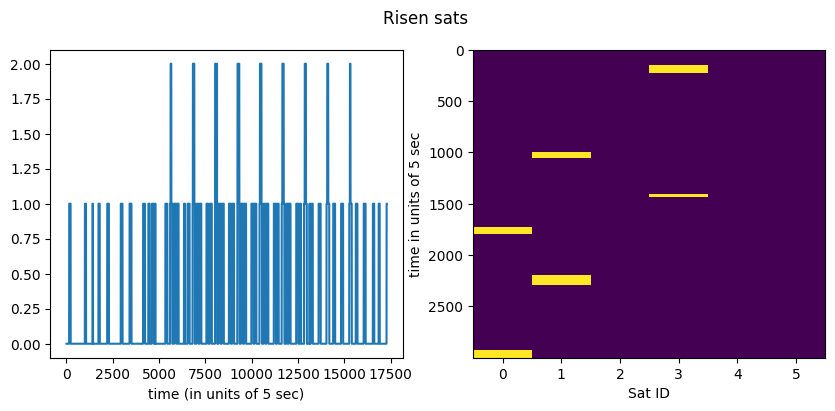

In [6]:
#satmap stuff

num_sats_risen = [len(x) for x in rsats]
satnums=[]
for s in rsats:
    if len(s)>0:
        for j in range(len(s)):
            satnums.append(s[j][0])

satids = set(satnums)
print(satids)
satlist = (np.array(list(satids)))
print(satlist)
satmap = {}
assert min(satlist) > len(
    satlist
)  # to make sure there are no collisions, we'll never have an i that's also a satnum
for i, satnum in enumerate(satlist):
    satmap[i] = satnum
    satmap[satnum] = i
arr = np.zeros((len(rsats), len(satlist)), dtype="int64")
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
fig.suptitle(f"Risen sats")
ax[0].plot(num_sats_risen)
ax[0].set_xlabel("time (in units of 5 sec)")
for i, row in enumerate(rsats):
    for satnum, satele,sataz in row:
        arr[i][satmap[satnum]] = 1
ax[1].set_ylabel("time in units of 5 sec")
ax[1].set_xlabel("Sat ID")
ax[1].imshow(arr[:3000],aspect='auto',interpolation="none")

[[[143, 222], [3]], [[990, 1054], [1]], [[1400, 1429], [3]], [[1723, 1794], [0]], [[2195, 2288], [1]], [[2926, 3022], [0]], [[3401, 3506], [1]], [[4130, 4236], [0]], [[4414, 4485], [5]], [[4605, 4714], [1]], [[4775, 4801], [2]], [[5333, 5441], [0]], [[5589, 5615], [4]], [[5615, 5655], [4, 5]], [[5655, 5711], [5]], [[5808, 5916], [1]], [[5971, 6048], [2]], [[6337, 6397], [3]], [[6533, 6641], [0]], [[6801, 6817], [4]], [[6817, 6896], [4, 5]], [[6896, 6923], [5]], [[7008, 7116], [1]], [[7175, 7274], [2]], [[7549, 7642], [3]], [[7732, 7840], [0]], [[8018, 8123], [4, 5]], [[8209, 8318], [1]], [[8379, 8486], [2]], [[8762, 8870], [3]], [[8932, 9040], [0]], [[9226, 9323], [4, 5]], [[9323, 9338], [4]], [[9415, 9522], [1]], [[9582, 9690], [2]], [[9974, 10087], [3]], [[10138, 10243], [0]], [[10413, 10436], [5]], [[10436, 10520], [4, 5]], [[10520, 10548], [4]], [[10629, 10727], [1]], [[10782, 10889], [2]], [[11185, 11297], [3]], [[11355, 11447], [0]], [[11610, 11644], [5]], [[11644, 11718], [4, 5]

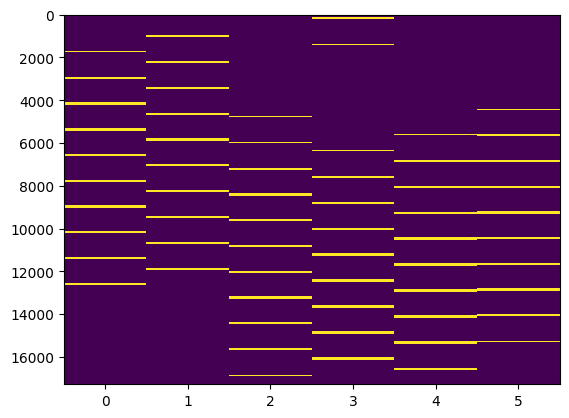

In [7]:
#get the pulses too
p = outils.get_simul_pulses(arr)
npulses = len(p)
print(p)

This is the mock satellite detection output

In [12]:
#pulses is now in seconds, with satID and with channel number of the pulse.

pulses = []
for i in range(len(p)):
    temp = []
    temp.append(np.array(p[i][0]) * 5)
    temp.append(int(satmap[p[i][1][0]]))
    pulses.append(temp)

print(pulses)

start_times = [ p[0][0] for p in pulses]
#print(start_times)
durations_secs = [p[0][1]- p[0][0] for p in pulses]
#print(durations_secs)
durations_chunks = [int((p[0][1]- p[0][0])/( T_SPECTRA * v_acclen )) for p in pulses]
#print(durations_chunks)
print("Number of Pulses:", npulses)


[[array([ 715, 1110]), 28654], [array([4950, 5270]), 59051], [array([7000, 7145]), 28654], [array([8615, 8970]), 44387], [array([10975, 11440]), 59051], [array([14630, 15110]), 44387], [array([17005, 17530]), 59051], [array([20650, 21180]), 44387], [array([22070, 22425]), 25338], [array([23025, 23570]), 59051], [array([23875, 24005]), 57166], [array([26665, 27205]), 44387], [array([27945, 28075]), 33591], [array([28075, 28275]), 33591], [array([28275, 28555]), 25338], [array([29040, 29580]), 59051], [array([29855, 30240]), 57166], [array([31685, 31985]), 28654], [array([32665, 33205]), 44387], [array([34005, 34085]), 33591], [array([34085, 34480]), 33591], [array([34480, 34615]), 25338], [array([35040, 35580]), 59051], [array([35875, 36370]), 57166], [array([37745, 38210]), 28654], [array([38660, 39200]), 44387], [array([40090, 40615]), 33591], [array([41045, 41590]), 59051], [array([41895, 42430]), 57166], [array([43810, 44350]), 28654], [array([44660, 45200]), 44387], [array([46130, 

Need a filtered pulses list (so that there are 5 good ones we can trust)

In [28]:
filtered_pulses = [[[715, 1110], [28654], [1836]], [[4950, 5270], [59051], [1836]], [[7000, 7145], [28654], [1836]], [[8615, 8970], [44387], [1836]], [[10975, 11440], [1]], [[14630, 15110], [0]]]

In [32]:
print(filtered_pulses[2][0][0])

7000


In [41]:
def phase_predictor(fit_coords, pulse_idx):
    
    #depends if I want to keep ant1 as reference in general
    ref_coords = coords[0]

    relative_start_time = filtered_pulses[pulse_idx][0][0]
    pulse_duration_sec = filtered_pulses[pulse_idx][0][1] - filtered_pulses[pulse_idx][0][0]
    pulse_duration_chunks = int( pulse_duration_sec / (T_SPECTRA * v_acclen) )

    time_start = global_start_time + relative_start_time
    sat_ID = filtered_pulses[pulse_idx][1][0]

    pulse_channel_idx = filtered_pulses[pulse_idx][2][0]
    pulse_freq = outils.chan2freq(pulse_channel_idx, alias=True)

    # 'd' has one entry per second
    d = outils.get_sat_delay(ref_coords, fit_coords, tle_path, time_start, iteration_time+1, sat_ID)
    # 'delay' has one entry per chunk (~0.5s) 
    delay = np.interp(np.arange(0, v_nchunks) * v_acclen * T_SPECTRA, np.arange(0, int(iteration_time)+1), d)
    #thus 'pred' has one entry for each chunk
    pred = (-delay[:pulse_duration_chunks]+ delay[0]) *  2*np.pi * pulse_freq

    return pred



catalog #59051 epoch 2024-07-24 21:55:34 UTC


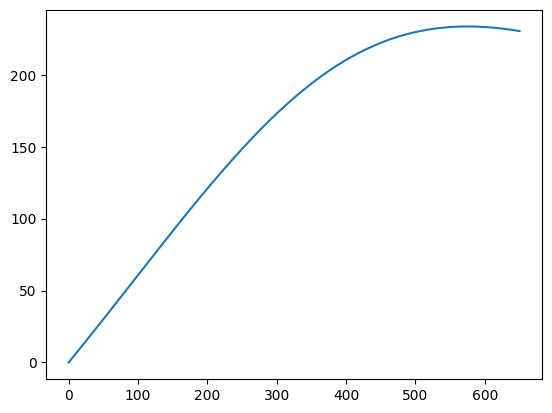

In [51]:
pred1 = phase_predictor(a2_coords, 1)
plt.plot(pred1)


catalog #59051 epoch 2024-07-24 21:55:34 UTC


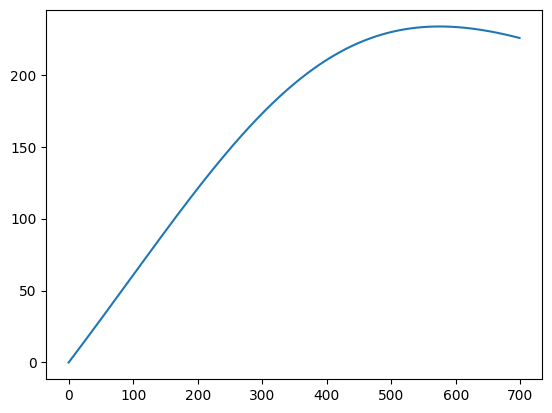

In [ ]:
#get delay array with an entry every second for all the iteration time
d = outils.get_sat_delay(
                    a1_coords,
                    a2_coords,
                    tle_path,
                    t_start,
                    iteration_time+1,
                    sat_ID,
                )

# get new array where each entry is for the start of each chunk:  spacing is every T_SPECTRA * v_acclen (about 16s usually)
delay = np.interp(
    np.arange(0, v_nchunks) * v_acclen * T_SPECTRA, np.arange(0, int(iteration_time)+1), d
)

pred = (-delay[:700]+ delay[0]) *  2*np.pi * pulse_freq
plt.plot(pred)        